## Airline Data Modeling

# Questions for Richard:
- how to pull out most important features? Random forest?
    - feature interpretability
    - unscale features 
- Should I undersample?
- XG or Random Forest Classifier

- start presentation
- Post model: Determine which features are most important
- business case, interpretability may not be necessary, cost of losing customer, proactive outreach
- Run testing data
- Watch visualization lecture


* Airlines are in trouble and customers are "up for grabs". 
* My audience is a group of C-leaders at an airline looking to understand how to retain current customers and capture new customers. 

In [452]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import itertools

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Model Support
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from matplotlib.colors import ListedColormap
from plot_metric.functions import BinaryClassification
from sklearn.datasets import make_classification
from scipy.spatial.distance import euclidean as euc
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc, plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, roc_auc_score, precision_recall_curve, fbeta_score)
from ipywidgets import interactive, FloatSlider



In [408]:
# imported CSV

df_model = pd.read_csv("/Users/Tara8082/GIT/ProjectGIT/Project_3/df_clean.csv", index_col = 0)

## Setting Up Model

In [409]:
# Designating 'neutral or dissatisfied' = 1, 'satisfied' = 0

df_model['Satisfaction'] = df_model['Satisfaction'].apply(lambda x: 1 if x == 'neutral or dissatisfied' else 0)

In [410]:
# Designates X (features), y (target)

features = ['Gender', 'Customer Type', 'Age', 'Type Of Travel', 'Class',
       'Flight Distance', 'Inflight Wifi Service', 'Dep Arr Time Convenience',
       'Ease Of Online Booking', 'Gate Location', 'Food And Drink',
       'Online Boarding', 'Seat Comfort', 'Inflight Entertainment',
       'Onboard Service', 'Leg Room Service', 'Baggage Handling',
       'Checkin Service', 'Inflight Service', 'Cleanliness',
       'Departure Delay In Minutes']

X = df_model[features]
y = df_model['Satisfaction']


In [411]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=6)

### Preprocessing: One Hot Encoding Categorical Features 

In [412]:
# Specify categorical features

categoricals = ['Gender', 'Customer Type', 'Type Of Travel', 'Class']
non_cat = ['Flight Distance', 'Inflight Wifi Service',
       'Dep Arr Time Convenience', 'Ease Of Online Booking',
       'Gate Location', 'Food And Drink', 'Online Boarding', 'Seat Comfort',
       'Inflight Entertainment', 'Onboard Service', 'Leg Room Service',
       'Baggage Handling', 'Checkin Service', 'Inflight Service',
       'Cleanliness', 'Departure Delay In Minutes']

ohe = OneHotEncoder(sparse=False)

cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals),
                           index=X_train.index)

# Combine continuous and categorical TRAINING data
X_train_preprocessed = pd.concat([X_train[non_cat], X_train_ohe], axis=1)

# Scale training data
ss = StandardScaler()
X_train_preprocessed = ss.fit_transform(X_train_preprocessed)


In [413]:
# Create validation set with X_train_preprocessed data

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_preprocessed, y_train, test_size=.3, random_state=2)


In [446]:
# Transform and scale TEST set --- DON'T TOUCH TEST UNTIL END.

cat_matrix_test = ohe.transform(X_test.loc[:, categoricals]) #only transform on the test set!

X_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=X_test.index)

# Combine continuous and categorical TEST data
X_test_preprocessed = pd.concat([X_test[non_cat], X_test_ohe], axis=1)

# Scale test data
X_test_preprocessed = ss.transform(X_test_preprocessed)

## K Nearest Neighbors

I will begin with K Nearest Neighbors by testing for the optimal k and associated root MSE in the range of 1-15.

In [65]:
# Testing for optimal k from 1-15

ks = range(1, 15)
test_errors = np.zeros(len(list(ks)))

for i,k in enumerate(ks):
    
    # Using nn for testing k
    nn = KNeighborsClassifier(n_neighbors = k)

    # Fit to training data
    nn.fit(X_train_scaled, y_train)

    # Predict on validation data
    test_k_preds = nn.predict(X_val_scaled)
    
    # Test errors = Mean Squared Errors of predictions/y-val
    test_errors[i] = np.sqrt(mean_squared_error(y_val, test_k_preds))
    print(k, test_errors[i])

1 0.2945393978724883
2 0.3018161170649324
3 0.2728927123983732
4 0.2723531316185696
5 0.2712029579942498
6 0.26593106101859343
7 0.26950260920725877
8 0.26627656078884776
9 0.26984353611043294
10 0.2684772309458182
11 0.2715417500788652
12 0.2690929267674012
13 0.27336397190490946
14 0.27072793680989765


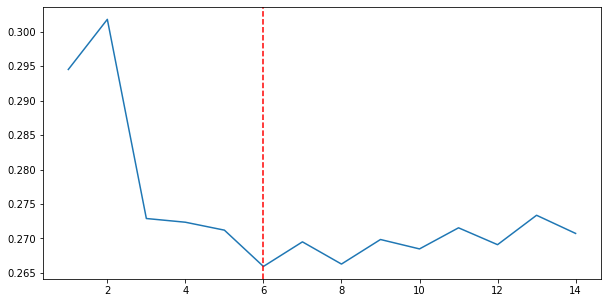

In [69]:
# graph K, test_error scores
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(list(ks), test_errors)
ax.axvline(list(ks)[np.argmin(test_errors)], linestyle='--', color='red');

In [109]:
# Finding optimal K and associated root MSE
optimal_k = list(ks)[np.argmin(test_errors)]

optimal_error = np.min(test_errors)

print(f'Optimal number of Neighbors: {optimal_k}\nRoot Mean Squared Error: {optimal_error:.4f}')

Optimal number of Neighbors: 6
Root Mean Squared Error: 0.2659


## KNN with Optimal k

In [151]:
knn = KNeighborsClassifier(n_neighbors = optimal_k)

# Fit to training data
knn.fit(X_train_scaled, y_train)

# Predict on scaled data
knn_preds = knn.predict(X_val_scaled)

In [152]:
print("Training score: ", knn.score(X_train_scaled, y_train))
print("Validation score: ", knn.score(X_val_scaled, y_val))

Training score:  0.9463970495523893
Validation score:  0.9292806707855251


In [153]:
print(classification_report(y_val, knn_preds))

# classification report shows how well classified what I hadn't seen

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     11782
           1       0.92      0.95      0.94     15410

    accuracy                           0.93     27192
   macro avg       0.93      0.93      0.93     27192
weighted avg       0.93      0.93      0.93     27192



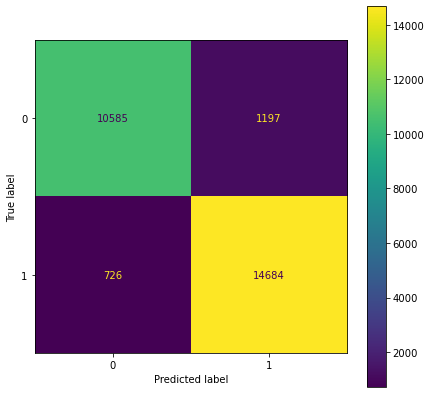

In [154]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_val_scaled, y_val, ax=ax); 

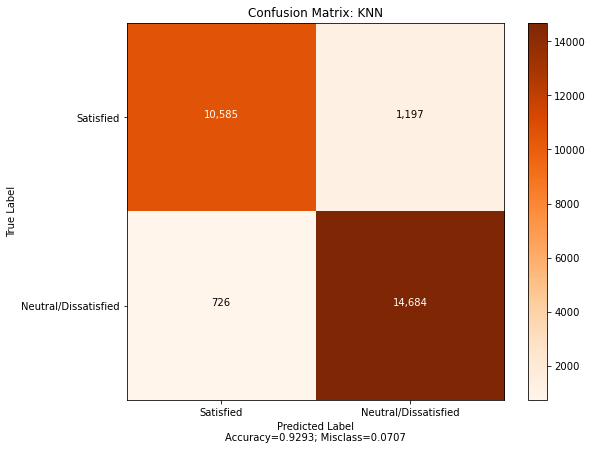

In [172]:
# Confustion Matrix with Optimal K
# Confusion Matrix --- looking at all of data to know which are TP, FP, 

knn_cm = confusion_matrix(y_val, knn_preds)
knn_cm
plot_kconfusion_matrix(knn_cm, normalize=False, target_names=['Satisfied', 'Neutral/Dissatisfied'], title='Confusion Matrix: {}'.format('KNN'))


### Cross Validating K

In [86]:
# Testing K for optimal k with cross validation

ks = range(1, 30)

cv_scores = np.zeros(len(list(ks)))

for i, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_score_mean = cross_val_score(knn, X_cval, y, cv=3).mean()
    cv_scores[i] = cv_score_mean

In [87]:
# Finding best K/score with cross validation
best_k = list(ks)[np.argmax(cv_scores)]

best_score = np.max(cv_scores)

print(f'Optimal number of Neighbors: {best_k}\nBest CV Score Mean: {best_score:.5f}')

Optimal number of Neighbors: 6
Best CV Score Mean: 0.92739


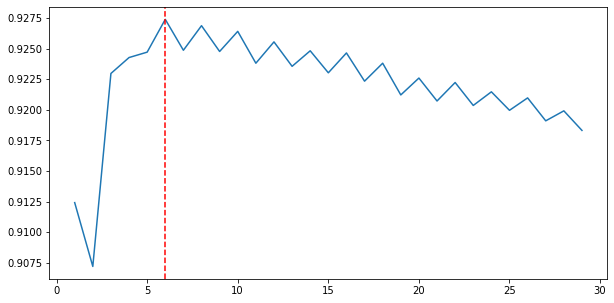

In [147]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(list(ks), cv_scores)
ax.axvline(list(ks)[np.argmax(cv_scores)], linestyle='--', color='red');

## Cross Validation on Scaled Models
- KNN
- Logistic Regression


In [ ]:
# Model_fit function

def model_fit(model, X_train_scaled, y_train):
    model.fit(X_train_scaled, y_train)
    return model.score(X_val_scaled, y_val)

### K Nearest Neighbors

In [220]:
knn = KNeighborsClassifier(n_neighbors = 6)

knn_cvs_score = cross_val_score(knn, X_train_scaled, y_train, cv=5)

print("Cross Validation Scores: ", knn_cvs_score)
print("Mean Score: ", knn_cvs_score.mean())

Cross Validation Scores:  [0.92434988 0.92332545 0.92308905 0.92568366 0.9269446 ]
Mean Score:  0.9246785284201844


In [221]:
model_fit(knn, X_train_scaled, y_train)
knn_pred = knn.predict(X_val_scaled)
print(classification_report(y_val, knn_pred))

print("=== All AUC Scores ===")
print(knn_cvs_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - K Nearest Neighbors: ", knn_cvs_score.mean())

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     11782
           1       0.92      0.95      0.94     15410

    accuracy                           0.93     27192
   macro avg       0.93      0.93      0.93     27192
weighted avg       0.93      0.93      0.93     27192

=== All AUC Scores ===
[0.92434988 0.92332545 0.92308905 0.92568366 0.9269446 ]


=== Mean AUC Score ===
Mean AUC Score - K Nearest Neighbors:  0.9246785284201844


=== Confusion Matrix ===
[[10585  1197]
 [  726 14684]]




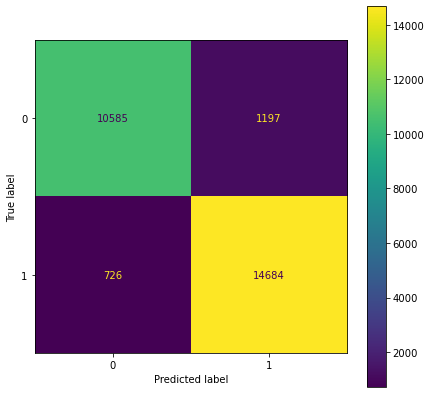

In [222]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, knn_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_val_scaled, y_val, ax=ax);

###  Logistic Regression

In [241]:
lr = LogisticRegression()
cvs = cross_val_score(lr, X_train_scaled, y_train, cv=5)

In [242]:
logistic = LogisticRegression(penalty='none')
model_fit(logistic, X_train_scaled, y_train)
log_val_pred = logistic.predict(X_val_scaled)

print(classification_report(y_val, log_val_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     11782
           1       0.88      0.90      0.89     15410

    accuracy                           0.88     27192
   macro avg       0.88      0.87      0.87     27192
weighted avg       0.88      0.88      0.88     27192



=== Confusion Matrix ===
[[ 9906  1876]
 [ 1476 13934]]




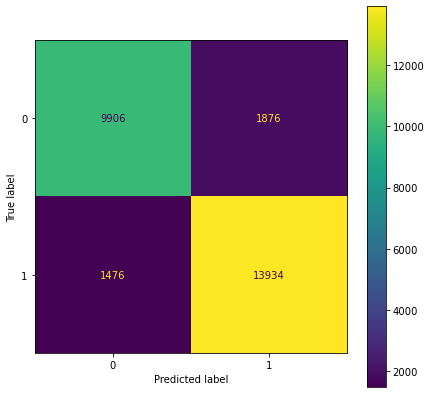

In [243]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, log_val_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(logistic, X_val_scaled, y_val, ax=ax);

## Unscaled Model Evaluation

- GaussianNB
- SVC
- Decision Tree Classifer
- Random Forest Classifier

### Gaussian

In [313]:
gauss = GaussianNB()
gauss_cvs_score = cross_val_score(gauss, X_train_scaled, y_train, cv=5)

In [314]:
model_fit(gauss, X_train_scaled, y_train)
gauss_pred = gauss.predict(X_val_scaled)
print(classification_report(y_val, gauss_pred))

print("=== All AUC Scores ===")
print(gauss_cvs_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Gaussian Classifier: ", gauss_cvs_score.mean())

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     11782
           1       0.87      0.88      0.87     15410

    accuracy                           0.85     27192
   macro avg       0.85      0.85      0.85     27192
weighted avg       0.85      0.85      0.85     27192

=== All AUC Scores ===
[0.85090623 0.84381403 0.84704492 0.8482938  0.84986997]


=== Mean AUC Score ===
Mean AUC Score - Gaussian Classifier:  0.8479857866629456


=== Confusion Matrix ===
[[ 9689  2093]
 [ 1922 13488]]




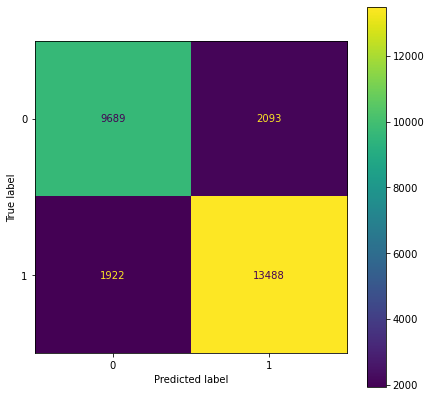

In [315]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, gauss_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gauss, X_val_scaled, y_val, ax=ax);

### SVC

In [316]:
svm = SVC()
svm_cvs_score = cross_val_score(svm, X_train_scaled, y_train, cv=5)

In [317]:
model_fit(svm, X_train_scaled, y_train)
svm_pred = svm.predict(X_val_scaled)
print(classification_report(y_val, svm_pred))

print("=== All AUC Scores ===")
print(svm_cvs_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - SVM Classifier: ", svm_cvs_score.mean())

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     11782
           1       0.95      0.97      0.96     15410

    accuracy                           0.95     27192
   macro avg       0.95      0.95      0.95     27192
weighted avg       0.95      0.95      0.95     27192

=== All AUC Scores ===
[0.95185185 0.94877857 0.94940898 0.94956261 0.94979904]


=== Mean AUC Score ===
Mean AUC Score - SVM Classifier:  0.9498802105855292


=== Confusion Matrix ===
[[10990   792]
 [  510 14900]]




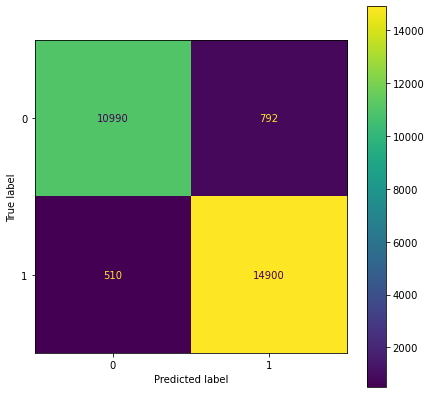

In [318]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,svm_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svm, X_val_scaled, y_val, ax=ax);

### Decision Tree Classifier

In [319]:
dtc = DecisionTreeClassifier()

dtc_cvs_score = cross_val_score(dtc, X_train_scaled, y_train, cv=5)

In [320]:
model_fit(dtc, X_train_scaled, y_train)
dtc_pred = dtc.predict(X_val_scaled)
print(classification_report(y_val, dtc_pred))

print("=== All AUC Scores ===")
print(dtc_cvs_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Decision Tree Classifier: ", dtc_cvs_score.mean())

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     11782
           1       0.95      0.95      0.95     15410

    accuracy                           0.94     27192
   macro avg       0.94      0.94      0.94     27192
weighted avg       0.94      0.94      0.94     27192

=== All AUC Scores ===
[0.94215918 0.93884949 0.94137116 0.93994799 0.94239105]


=== Mean AUC Score ===
Mean AUC Score - Decision Tree Classifier:  0.9409437720887913


=== Confusion Matrix ===
[[11020   762]
 [  791 14619]]




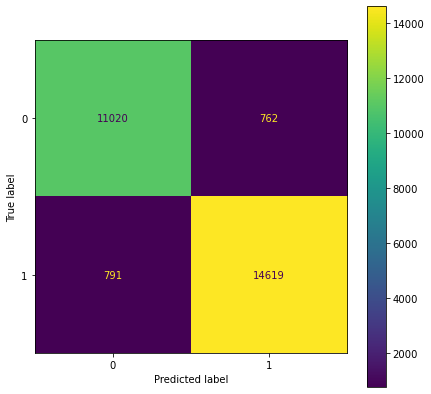

In [321]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, dtc_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(dtc, X_val_scaled, y_val, ax=ax);

### Random Forest Classifier

In [322]:
model_fit(rfc, X_train_scaled, y_train)
rfc_pred = rfc.predict(X_val_scaled)
print(classification_report(y_val, rfc_pred))

print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11782
           1       0.96      0.98      0.97     15410

    accuracy                           0.96     27192
   macro avg       0.96      0.96      0.96     27192
weighted avg       0.96      0.96      0.96     27192

=== All AUC Scores ===
[0.95965327 0.95910165 0.95681639 0.95736465 0.96012294]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9586117807342424


=== Confusion Matrix ===
[[11088   694]
 [  370 15040]]




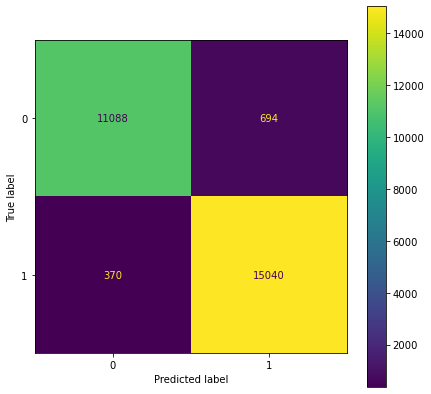

In [323]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, rfc_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rfc, X_val_scaled, y_val, ax=ax);

### XGBoost

In [415]:
xgb = XGBClassifier()

xgb_cv_score = cross_val_score(xgb, X_train_scaled, y_train, cv=5)

model_fit(xgb, X_train_scaled, y_train)
xgb_pred = xgb.predict(X_val_scaled)
print(classification_report(y_val, xgb_pred))

print("=== All AUC Scores ===")
print(xgb_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGB: ", xgb_cv_score.mean())

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11782
           1       0.96      0.98      0.97     15410

    accuracy                           0.96     27192
   macro avg       0.96      0.96      0.96     27192
weighted avg       0.96      0.96      0.96     27192

=== All AUC Scores ===
[0.95910165 0.95815603 0.95918046 0.95626133 0.95854677]


=== Mean AUC Score ===
Mean AUC Score - XGB:  0.9582492483546335


=== Confusion Matrix ===
[[11092   690]
 [  366 15044]]




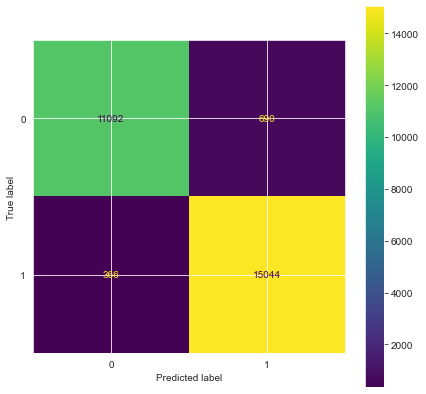

In [425]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, xgb_pred))
print('\n')

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(xgb, X_val_scaled, y_val, ax=ax);

### XGBoost gives best recall scores. 

I am unscaling the data to derive feature importance.

In [453]:
# Unscale training and validation data for models without scaling

X_train_inversed = ss.inverse_transform(X_train_scaled)
X_val_inversed = ss.inverse_transform(X_val_scaled)

# Unscaled XGBoost Model
xgb2 = XGBClassifier()

xgb2_cv_score = cross_val_score(xgb2, X_train_inversed, y_train, cv=5)

model_fit(xgb2, X_train_inversed, y_train)
xgb_pred2 = xgb2.predict(X_val_inversed)
print(classification_report(y_val, xgb_pred2))

print("=== All AUC Scores ===")
print(xgb2_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGB: ", xgb2_cv_score.mean())

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11782
           1       0.96      0.98      0.97     15410

    accuracy                           0.96     27192
   macro avg       0.96      0.96      0.96     27192
weighted avg       0.96      0.96      0.96     27192

=== All AUC Scores ===
[0.95910165 0.95815603 0.95918046 0.95626133 0.95854677]


=== Mean AUC Score ===
Mean AUC Score - XGB:  0.9582492483546335


In [454]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold

    y_predict = (model.predict_proba(X_val_inversed)[:, 1] >= threshold)
    airline_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(airline_confusion, cmap=plt.cm.Oranges, annot=True, square=True, fmt='d',
           xticklabels=['Satisfied', 'Dissatisfied/Neutral'],
           yticklabels=['Satisfied', 'Dissatisfied/Neutral']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

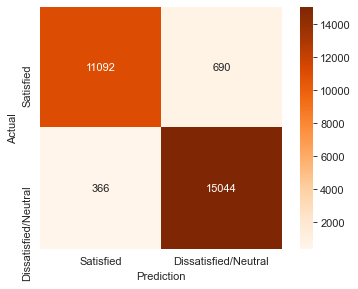

In [455]:
make_confusion_matrix(xgb2)

In [456]:
interactive(lambda threshold: make_confusion_matrix(xgb2, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

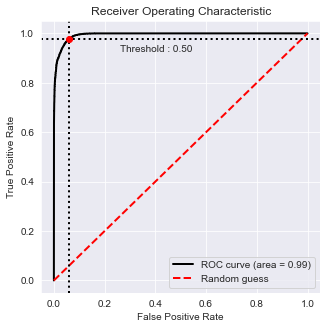

In [457]:
# Plot ROC curvea and AUC
y_pred_proba = xgb2.predict_proba(X_val_inversed)[:,1]

# Visualization with plot_metric
bc = BinaryClassification(y_val, y_pred_proba, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()


True Class  Predicted Proba Predicted Type Predicted Class
7194             0         0.000029             TN         Class 1
105550           1         0.999708             TP         Class 2
5641             0         0.042768             TN         Class 1
3762             1         0.999826             TP         Class 2
117039           0         0.009691             TN         Class 1
...            ...              ...            ...             ...
54935            1         0.999494             TP         Class 2
101803           1         0.999574             TP         Class 2
119977           1         0.868318             TP         Class 2
26225            0         0.000551             TN         Class 1
91304            0         0.001918             TN         Class 1

[27192 rows x 4 columns]

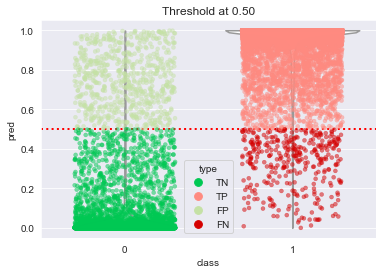

In [458]:
bc.plot_class_distribution()

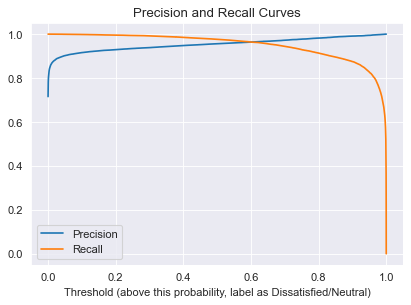

In [459]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, xgb2.predict_proba(X_val_inversed)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='Precision')
plt.plot(threshold_curve, recall_curve[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Dissatisfied/Neutral)');
plt.title('Precision and Recall Curves');

In [460]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_val, xgb2.predict_proba(X_val_inversed)[:,1])

ROC AUC score =  0.9942801362982787


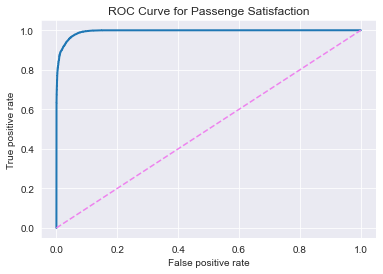

In [461]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve for Passenge Satisfaction');
print("ROC AUC score = ", roc_auc_score(y_val, xgb2.predict_proba(X_val_inversed)[:,1]))

In [462]:
def plot_feature_importance(model, features):
    importance = model.feature_importances_
    feature_importance = list(zip(features, importance))
    feature_importance.sort(key = lambda x: x[1])
    # split sorted features_importance into x,y
    feat = [f[0] for f in feature_importance]
    imp = [i[1] for i in feature_importance]
    # Plot feature importance
    plt.figure(figsize=(8, 6), dpi=100)
    plt.title('Feature Importance: XGBoost Model', fontsize=12)
    plt.barh(feat, imp)
    plt.xlabel('Feature Score', fontsize=10)
    sns.despine(bottom = True, left = True)
    plt.show();

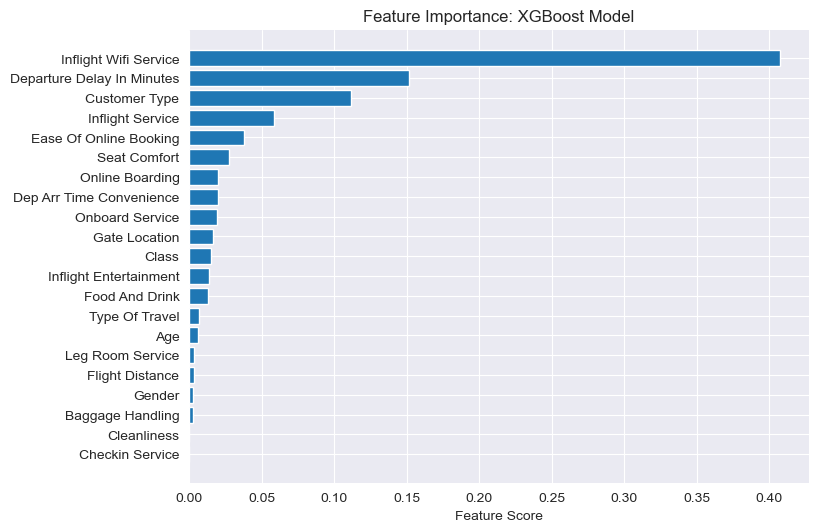

In [463]:
plot_feature_importance(xgb2, features)

### XGBoost with Testing Data

* Do I need to created a new model or can I just predicton test set?

In [464]:
X_test_inversed = ss.inverse_transform(X_test_preprocessed)

In [467]:
xgb_test_preds = xgb2.predict(X_test_inversed)
print(classification_report(y_test, xgb_test_preds))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     16825
           1       0.95      0.98      0.97     22022

    accuracy                           0.96     38847
   macro avg       0.96      0.96      0.96     38847
weighted avg       0.96      0.96      0.96     38847



In [469]:
def make_confusion_matrix_test(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold

    y_predict_test = (model.predict_proba(X_test_inversed)[:, 1] >= threshold)
    airline_confusion_test = confusion_matrix(y_test, y_predict_test)
    plt.figure(dpi=80)
    sns.heatmap(airline_confusion_test, cmap=plt.cm.Oranges, annot=True, square=True, fmt='d',
           xticklabels=['Satisfied', 'Dissatisfied/Neutral'],
           yticklabels=['Satisfied', 'Dissatisfied/Neutral']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

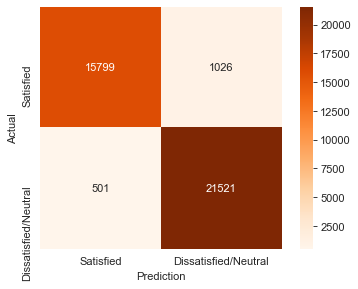

In [470]:
make_confusion_matrix_test(xgb2)

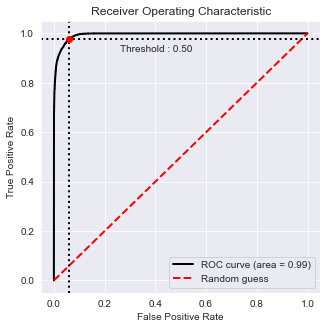

In [468]:
# Plot ROC curvea and AUC
y_test_proba = xgb2.predict_proba(X_test_inversed)[:,1]

# Visualization with plot_metric
bc = BinaryClassification(y_test, y_test_proba, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()